<a href="https://colab.research.google.com/github/sanyamjain789523/personalProjects/blob/main/pytorch_bert_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline DL model

### import the libraries

In [ ]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("/df_final28May.csv

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3132 entries, 0 to 3131
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      3132 non-null   int64 
 1   preprocessed2   3132 non-null   object
 2   Classification  3132 non-null   object
dtypes: int64(1), object(2)
memory usage: 73.5+ KB


### In the original dataset there're two classes "minor" and "minor ", the latter needs to be corrected in order to avoid evaluation of an extra class.

In [ ]:
df["Classification"] = df.Classification.apply(lambda x: x.strip())

In [ ]:
df['preprocessed2'][0]

'uas while during departure from westhampton beach no evasive action take west hampton beach'

In [ ]:
# train_posts and train_tags are just X_train and y_train

train_posts = df["preprocessed2"]
train_tags = df["Classification"]


In [ ]:
df.Classification.value_counts()

Minimal         1026
Minor            870
Hazardous        841
Catastrophic     395
Name: Classification, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3132 entries, 0 to 3131
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      3132 non-null   int64 
 1   preprocessed2   3132 non-null   object
 2   Classification  3132 non-null   object
dtypes: int64(1), object(2)
memory usage: 73.5+ KB


### Description of some of the terminologies below:
  1. vocab_size: represents the maximum number of words we're gonna be taking into account when being ranked in decreasing frequency of each.
  2. batch_size: This represents the number of data points that'll be passed into the neural network layer at once, if not initiated this will in turn take too much of time.
  3. num_epocs: represents the number of epochs, which simply means the times we want the data to iterate through the entire dataset.
  4. encoder: The encoder basically encodes the string values of the label feature to one hot representation.
  5. tokenizer : tokenizer is responsible to covert the string input values to numric values to numeric representations, herein we're using tfidf mode.

In [ ]:
train_tags

3129         Minimal
1831         Minimal
2832       Hazardous
2938       Hazardous
1571           Minor
            ...     
948          Minimal
2957         Minimal
2671       Hazardous
980        Hazardous
2801    Catastrophic
Name: Classification, Length: 2505, dtype: object

In [ ]:

vocab_size = 15000
batch_size = 100
num_epochs = 30

X = df.drop(['Classification'], axis = 1)
Y = df['Classification']
train_posts, test_posts, train_tags, test_tags = train_test_split(X,Y, test_size = 0.2, random_state = 42,stratify=Y)

# # lets take 80% data as training and remaining 20% for test.
# train_size = int(len(df) * .8)

train_posts = train_posts["preprocessed2"]
train_tags = train_tags

test_posts = test_posts["preprocessed2"]
test_tags = test_tags

# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_posts)

x_train = tokenizer.texts_to_matrix(train_posts, mode='tfidf')
# x_test = tokenizer.texts_to_matrix(test_posts, mode='tfidf')

encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

*We*'re using the keras sequential API here.

Being a baseline model I'm using ANN that is artificial neural network here, to initiate that we use Dense layer from keras.
Since the labels to be predicted is 4, we're using softmax activation function at last layer to output the probability of each class predictions.

And hence printing the model architecture.


In [ ]:
num_labels = 4
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               7680512   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2

Training the model,
the model below is slightly overfitted, but it can always be tweaked by just reducing the number of epochs.

In [ ]:

num_epochs =3
batch_size = 128
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    # verbose=2,
                    validation_split=0.2)


Epoch 1/3
16/16 [==============================] - 18s 58ms/step - loss: 1.2821 - accuracy: 0.4174 - val_loss: 0.9095 - val_accuracy: 0.6946
Epoch 2/3
16/16 [==============================] - 0s 19ms/step - loss: 0.5628 - accuracy: 0.8566 - val_loss: 0.6173 - val_accuracy: 0.7864
Epoch 3/3
16/16 [==============================] - 0s 17ms/step - loss: 0.1635 - accuracy: 0.9475 - val_loss: 0.7159 - val_accuracy: 0.7745


generating the predictions on the test set

In [ ]:
x_t = tokenizer.texts_to_matrix(test_posts, mode='tfidf')

y_pred = model.predict_on_batch(x_t)
# y_pred

generating the confusion matrix

In [ ]:
from sklearn import metrics

matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
# matrix

In [ ]:
encoder.classes_

array(['Catastrophic', 'Hazardous', 'Minimal', 'Minor'], dtype='<U12')

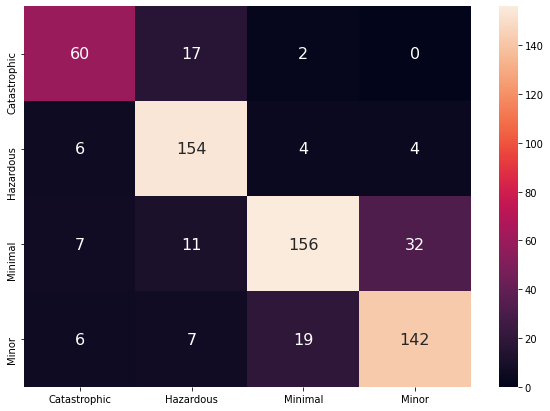

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
l = ['Catastrophic', 'Hazardous', 'Minimal', 'Minor']
df_cm = pd.DataFrame(matrix, index = [i for i in "ABCD"],
                  columns = [i for i in "ABCD"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=l, yticklabels=l, fmt='g')

###The confusion matrix plotted above conveys as follows:

66 Catastrophic labels were predicted correctly, while 11 were predicted as Hazardous,5 as Minimal and 2 as Minor.

148 Hazardous labels were predicted correctly, while 9 were predicted as Catastrophic,15 as Minimal and 2 as Minor.

171 Minimal labels were predicted correctly, while 5 were predicted as Catastrophic,14 as Hazardous and 22 as Minor.

128 Minor labels were predicted correctly, while 2 were predicted as Catastrophic,8 as Hazardous and 19 as Minimal.


generating the classification report

In [ ]:
classReport = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=l)
print(classReport)

              precision    recall  f1-score   support

Catastrophic       0.76      0.76      0.76        79
   Hazardous       0.81      0.92      0.86       168
     Minimal       0.86      0.76      0.81       206
       Minor       0.80      0.82      0.81       174

    accuracy                           0.82       627
   macro avg       0.81      0.81      0.81       627
weighted avg       0.82      0.82      0.82       627



# Tweaked Deeplearning

The same workflow as above follows, with just some tweakings like

introducing an Embedding layer, an LSTM layer and changing some hyperparameters.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [ ]:
data = pd.read_csv('/df_final28May.csv')

print(data.shape)


(3132, 3)


In [ ]:
# data.head()

In [ ]:
def xyz(x):
  return x.lower()

In [ ]:
    
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['preprocessed2'].values)
X = tokenizer.texts_to_sequences(data['preprocessed2'].values)
X = pad_sequences(X)

In [ ]:
# [0.44,0.23,....]
# [0]

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 46, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 46, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 788       
Total params: 511,588
Trainable params: 511,588
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
Y = pd.get_dummies(data['Classification']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42,stratify=Y)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2505, 46) (2505, 4)
(627, 46) (627, 4)


In [ ]:
batch_size = 32
model.fit(X, Y, epochs = 7, batch_size=batch_size, validation_split=0.2)

Epoch 1/7
79/79 [==============================] - 24s 180ms/step - loss: 1.2794 - accuracy: 0.3379 - val_loss: 0.8965 - val_accuracy: 0.5566
Epoch 2/7
79/79 [==============================] - 13s 170ms/step - loss: 0.8235 - accuracy: 0.5967 - val_loss: 0.6209 - val_accuracy: 0.7560
Epoch 3/7
79/79 [==============================] - 14s 171ms/step - loss: 0.5453 - accuracy: 0.7931 - val_loss: 0.4716 - val_accuracy: 0.8437
Epoch 4/7
79/79 [==============================] - 13s 170ms/step - loss: 0.3984 - accuracy: 0.8558 - val_loss: 0.4559 - val_accuracy: 0.8660
Epoch 5/7
79/79 [==============================] - 14s 171ms/step - loss: 0.3411 - accuracy: 0.8894 - val_loss: 0.4331 - val_accuracy: 0.8549
Epoch 6/7
79/79 [==============================] - 14s 171ms/step - loss: 0.2778 - accuracy: 0.9085 - val_loss: 0.3768 - val_accuracy: 0.8852
Epoch 7/7
79/79 [==============================] - 13s 171ms/step - loss: 0.2210 - accuracy: 0.9299 - val_loss: 0.3623 - val_accuracy: 0.8804


In [ ]:

y_pred = model.predict_on_batch(X_test)
y_pred

array([[0.00790529, 0.96705884, 0.02076518, 0.00427064],
       [0.00249917, 0.00692203, 0.96405953, 0.02651922],
       [0.10551442, 0.87960994, 0.0040263 , 0.01084937],
       ...,
       [0.07909559, 0.90729153, 0.00309757, 0.01051529],
       [0.08519192, 0.8940653 , 0.00823976, 0.01250302],
       [0.01248156, 0.8580525 , 0.11841104, 0.0110549 ]], dtype=float32)

In [ ]:
from sklearn import metrics

matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
# matrix

array([[ 69,   8,   1,   1],
       [  4, 160,   4,   0],
       [  0,   3, 201,   2],
       [  1,   2,   8, 163]])

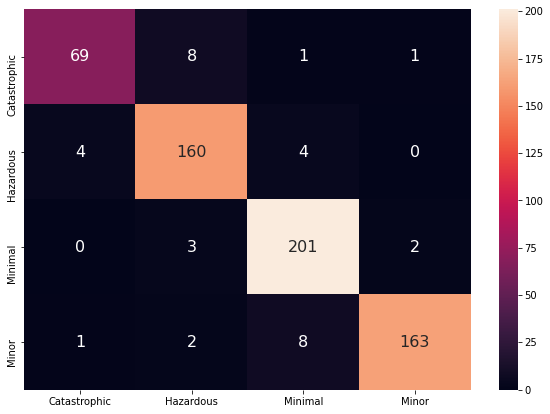

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
l = ['Catastrophic', 'Hazardous', 'Minimal', 'Minor']
df_cm = pd.DataFrame(matrix, index = [i for i in "ABCD"],
                  columns = [i for i in "ABCD"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=l, yticklabels=l, fmt='g')

###The confusion matrix plotted above conveys as follows:

69 Catastrophic labels were predicted correctly, while 4 were predicted as Hazardous,0 as Minimal and 1 as Minor.

160 Hazardous labels were predicted correctly, while 8 were predicted as Catastrophic,3 as Minimal and 2 as Minor.

201 Minimal labels were predicted correctly, while 1 were predicted as Catastrophic,4 as Hazardous and 8 as Minor.

163 Minor labels were predicted correctly, while 1 were predicted as Catastrophic,0 as Hazardous and 2 as Minimal.


In [ ]:
classReport = metrics.classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=l)
print(classReport)

              precision    recall  f1-score   support

Catastrophic       0.93      0.87      0.90        79
   Hazardous       0.92      0.95      0.94       168
     Minimal       0.94      0.98      0.96       206
       Minor       0.98      0.94      0.96       174

    accuracy                           0.95       627
   macro avg       0.94      0.93      0.94       627
weighted avg       0.95      0.95      0.95       627



# Using BERT

### kindly make sure to execute the cell below before running the code for bert

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 31.9MB/s 
     |████████████████████████████████| 901kB 39.2MB/s 
     |████████████████████████████████| 3.3MB 36.7MB/s 


some imports and preprocessing

In [ ]:
import torch
from tqdm.notebook import tqdm
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [ ]:
df = pd.read_csv('/df_final28May.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3132 entries, 0 to 3131
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      3132 non-null   int64 
 1   preprocessed2   3132 non-null   object
 2   Classification  3132 non-null   object
dtypes: int64(1), object(2)
memory usage: 73.5+ KB


In [ ]:
df['Classification'].value_counts()

Minimal         1026
Minor            870
Hazardous        841
Catastrophic     395
Name: Classification, dtype: int64

In [ ]:
possible_labels = df.Classification.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'Catastrophic': 1, 'Hazardous': 2, 'Minimal': 0, 'Minor': 3}

In [ ]:
df['label'] = df.Classification.replace(label_dict)

In [ ]:
df.head(1)

,Unnamed: 0,preprocessed2,Classification,label
0,0,uas while during departure from westhampton be...,Minimal,0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.2, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [ ]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
df.groupby(['Classification', 'label', 'data_type']).count()

Unnamed: 0  preprocessed2
Classification label data_type                           
Catastrophic   1     train             316            316
                     val                79             79
Hazardous      2     train             673            673
                     val               168            168
Minimal        0     train             820            820
                     val               206            206
Minor          3     train             696            696
                     val               174            174

initialization of the BERT tokenizer, with vocab of lower cased words

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

encoding the input text as per the BERT requirements, this aslo generates attention masks and padded input variant of the layer correspondingly.

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].preprocessed2.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].preprocessed2.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


converting the encoded values to tensors so could be passed into BERT architecture.

In [ ]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [ ]:
len(dataset_train), len(dataset_val)

(2505, 627)

Initialization of the BERT Model

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

This cell converts the above obtained to tensors to pytorch datasets

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

initialization of ADAM optimizer

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [ ]:
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

Making functions for metrics later to be used in training the model.

In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    totalCorrect = 0
    total = 0
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        totalCorrect += len(y_preds[y_preds==label])
        total += len(y_true)

    return {"accuracy":float(totalCorrect/total)}

setting seeds to avoid different results in different executions

In [ ]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


The evaluate function helps in evaluating the model performance by providing the loss values, true y values and predicted y values

In [ ]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

training the BERT model and saving the each configuration after each respective epoch

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/content/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 0.6745451193576132
Validation loss: 0.4522395780751188
F1 Score (Weighted): 0.9090778604483577



Epoch 2
Training loss: 0.4418928925076243
Validation loss: 0.3929085277007563
F1 Score (Weighted): 0.9360503802567893



Epoch 3
Training loss: 0.33669823662232895
Validation loss: 0.31984977969904227
F1 Score (Weighted): 0.9522185797652778



Epoch 4
Training loss: 0.25144349618669887
Validation loss: 0.334787063071121
F1 Score (Weighted): 0.9475715917021742



Epoch 5
Training loss: 0.2343722162570269
Validation loss: 0.3191140925132393
F1 Score (Weighted): 0.9523375460860726



Epoch 6
Training loss: 0.18914373404246024
Validation loss: 0.3219011538635837
F1 Score (Weighted): 0.9538547111484099



Epoch 7
Training loss: 0.15234523900550329
Validation loss: 0.3070926264807934
F1 Score (Weighted): 0.9507085792124591



Epoch 8
Training loss: 0.12888111096352317
Validation loss: 0.33041494759621265
F1 Score (Weighted): 0.9491805832104865



Epoch 9
Training loss: 0.11331077154166717
Validation loss: 0.31953901479201186
F1 Score (Weighted): 0.9506860766477334



Epoch 10
Training loss: 0.09047952268710416
Validation loss: 0.3034936283995246
F1 Score (Weighted): 0.9554700447224315



initializing the "model" again

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

using the weights generated during training and load them into the above initialised model.

In [ ]:
model.load_state_dict(torch.load(f'/content/finetuned_BERT_epoch_{epochs-1}.model', map_location=torch.device('cpu')))

<All keys matched successfully>

generating predictions

In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [ ]:
accuracy_per_class(predictions, true_vals)

Class: Minimal
Accuracy: 192/206

Class: Catastrophic
Accuracy: 73/79

Class: Hazardous
Accuracy: 163/168

Class: Minor
Accuracy: 168/174



{'accuracy': 0.9505582137161085}

### Making the confusion matrix and the classification report.

In [ ]:
from sklearn import metrics

matrix = metrics.confusion_matrix(true_vals, predictions.argmax(axis=1))
matrix

array([[192,   1,   3,  10],
       [  0,  73,   4,   2],
       [  1,   0, 163,   4],
       [  2,   1,   3, 168]])

In [ ]:
# , labels=None
# {'Catastrophic': 1, 'Hazardous': 2, 'Minimal': 0, 'Minor': 3}

from sklearn import metrics

matrix = metrics.confusion_matrix(true_vals, predictions.argmax(axis=1), labels=[1, 2, 0, 3])
matrix

array([[ 73,   4,   0,   2],
       [  0, 163,   1,   4],
       [  1,   3, 192,  10],
       [  1,   3,   2, 168]])

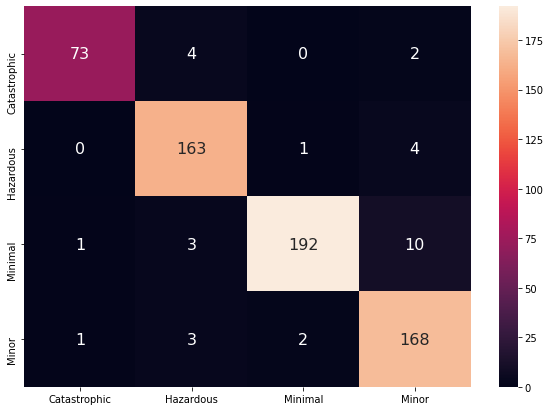

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
l = ['Catastrophic', 'Hazardous', 'Minimal', 'Minor']
df_cm = pd.DataFrame(matrix, index = [i for i in "ABCD"],
                  columns = [i for i in "ABCD"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=l, yticklabels=l, fmt='g')

###The confusion matrix plotted above conveys as follows:

72 Catastrophic labels were predicted correctly, while 1 were predicted as Hazardous,1 as Minimal and 1 as Minor.

162 Hazardous labels were predicted correctly, while 4 were predicted as Catastrophic,4 as Minimal and 6 as Minor.

195 Minimal labels were predicted correctly, while 1 were predicted as Catastrophic,1 as Hazardous and 1 as Minor.

166 Minor labels were predicted correctly, while 2 were predicted as Catastrophic,4 as Hazardous and 6 as Minimal.


In [ ]:
classReport = metrics.classification_report(true_vals, predictions.argmax(axis=1),target_names=l)
print(classReport)

              precision    recall  f1-score   support

Catastrophic       0.98      0.95      0.97       206
   Hazardous       0.96      0.91      0.94        79
     Minimal       0.92      0.96      0.94       168
       Minor       0.93      0.95      0.94       174

    accuracy                           0.95       627
   macro avg       0.95      0.94      0.95       627
weighted avg       0.95      0.95      0.95       627

